#Rekomendasi Tempat Wisata di Indonesia

Sistem Rekomendasi yang dibuat merupakan sistem rekomendasi yang termasuk ke dalam Collaborative Filtering dimana sistem akan me-filter variabel berdasarkan model yang dibuat. Dataset yang digunakan merupakan dataset yang berasal dari Kaggle dengan judul "Indonesia Tourism Destination" yang dapat diakses pada [link](https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination?select=tourism_with_id.csv) ini. 

![gambar](https://th.bing.com/th/id/OIP.4x_aEG3I8M8gropN1eV0BwHaC5?pid=ImgDet&rs=1)

In [1]:
#Memasukan library yang diperlukan
import pandas as pd
import numpy as np 
import zipfile 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import os

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [4]:
#konfigurasi untuk import dataset dari kaggle
! chmod 600 /content/kaggle.json

In [5]:
#download dataset dengan API kaggle
! kaggle datasets download -d aprabowo/indonesia-tourism-destination

  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 53.6MB/s]


In [6]:
#membuka file zip
local_file = '/content/indonesia-tourism-destination.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('/content/id')
zip_ref.close()

## Data Loading

In [7]:
#variabel dataset yang digunakan
df = pd.read_csv('/content/id/tourism_rating.csv')
df

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


## Deskripsi Variabel

Dapat dilihat bahwa data yang tersedia memiliki 3 kolom variabel yaitu User_Id, Place_Id, dan Place_Ratings. Adapun deskripsi dari variabel tersebut ialah sebagai berikut:
* User_Id : berisikan sekumpulan data unik dari user atau dalam kasus dataset ini, merupakan para wisatawan
* Place_Id : berisikan kode unik yang mempresentasikan tempat wisata di Indonesia
* Place_Ratings : berisikan rating atau penilaian yang diberikan oleh user (wisatawan) terhadap tempat wisata yang telah dikunjungi

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


Berdasarkan informasi dataset diatas, dapat dilihat bahwa ketiga kolom yang ada merupakan kolom dengan tiper data int64

## Data Preparation
Pada tahap data preparation yang perlu dilakukan ialah mempersiapkan data untuk menyandikan (encode) fitur ‘User_Id’ dan ‘Place_Id’ ke dalam indeks integer.

In [9]:
# Encoding User_Id
user_ids = df['User_Id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

In [10]:
#Encoding Place_Id
place_ids = df['Place_Id'].unique().tolist()
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}

Setelah menyandikan fitur-fitur tersebut, langkah selanjutnya adalah memetakan ke dataframe yang berkaitan

In [11]:
# Mapping User_Id ke dataframe user
df['user'] = df['User_Id'].map(user_to_user_encoded)
# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

Tahap terakhir yaitu mengecek beberapa hal dalam data seperti jumlah user, jumlah tempat, dan mengubah nilai rating menjadi float.

In [12]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)
 
# Mendapatkan jumlah place
num_place = len(place_encoded_to_place)
print(num_place)
 
# Mengubah rating menjadi nilai float
df['rating'] = df['Place_Ratings'].values.astype(np.float32)
 
# Nilai minimum rating
min_rating = min(df['rating'])
 
# Nilai maksimal rating
max_rating = max(df['rating'])
 
print('Number of User: {}, Number of Place: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_place, min_rating, max_rating
))

300
437
Number of User: 300, Number of Place: 437, Min Rating: 1.0, Max Rating: 5.0


## Splitting Data for Training and Validation

Tahap ini ialah membagi dataset menjadi data training dan data validasi. Data training akan dijadikan data untuk saat training model berlangsung sedangkan data validasi adalah untuk memvalidasi model yang sudah terbentuk (testing). Sebelum dilakukan pembagian, dataset terlebih dahulu diacak terlebih dahulu agar model lebih terbiasa dengan data acak atau tidak berurutan.

In [13]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,User_Id,Place_Id,Place_Ratings,user,place,rating
6252,188,207,3,187,262,3.0
4684,142,268,2,141,83,2.0
1731,54,103,3,53,10,3.0
4742,144,119,3,143,141,3.0
4521,138,288,5,137,283,5.0
...,...,...,...,...,...,...
5734,173,402,5,172,175,5.0
5191,157,85,4,156,33,4.0
5390,163,18,3,162,52,3.0
860,28,416,4,27,187,4.0


Pembagian dilakukan dengan rasio 80:20

In [14]:
# Membuat variabel x untuk mencocokkan data user dan tempat menjadi satu value
x = df[['user', 'place']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [23]:
#tampilan data yang akan diproses model
print(x_train, y_train)

[[187 262]
 [141  83]
 [ 53  10]
 ...
 [223 337]
 [ 19 319]
 [206 112]] [0.5  0.25 0.5  ... 1.   0.5  1.  ]


## Training Procces

Pada tahap ini, model menghitung skor kecocokan antara user dan tempat dengan teknik embedding. Pertama, kita melakukan proses embedding terhadap data user dan tempat. Selanjutnya, lakukan operasi perkalian dot product antara embedding user dan tempat. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.

In [16]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_place, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_place = num_place
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.place_embedding = layers.Embedding( # layer embeddings place
        num_place,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.place_bias = layers.Embedding(num_place, 1) # layer embedding resto bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    place_vector = self.place_embedding(inputs[:, 1]) # memanggil layer embedding 3
    place_bias = self.place_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_place = tf.tensordot(user_vector, place_vector, 2) 
 
    x = dot_user_place + user_bias + place_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

Melakukan compile model

In [17]:
model = RecommenderNet(num_users, num_place, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [18]:
# Memulai training
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 100,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
80/80 [==============================] - 2s 6ms/step - loss: 0.7144 - root_mean_squared_error: 0.3597 - val_loss: 0.7122 - val_root_mean_squared_error: 0.3579
Epoch 2/100
80/80 [==============================] - 0s 3ms/step - loss: 0.7195 - root_mean_squared_error: 0.3618 - val_loss: 0.7141 - val_root_mean_squared_error: 0.3592
Epoch 3/100
80/80 [==============================] - 0s 3ms/step - loss: 0.7259 - root_mean_squared_error: 0.3666 - val_loss: 0.7161 - val_root_mean_squared_error: 0.3605
Epoch 4/100
80/80 [==============================] - 0s 3ms/step - loss: 0.7405 - root_mean_squared_error: 0.3744 - val_loss: 0.7160 - val_root_mean_squared_error: 0.3605
Epoch 5/100
80/80 [==============================] - 0s 3ms/step - loss: 0.7943 - root_mean_squared_error: 0.4037 - val_loss: 0.7152 - val_root_mean_squared_error: 0.3599
Epoch 6/100
80/80 [==============================] - 0s 3ms/step - loss: 0.7952 - root_mean_squared_error: 0.4028 - val_loss: 0.7121 - val_root_m

## Metric Visualitation

Visualiasi training model dapat dilakukan dengan mem-plot-kan metrik evaluasi dengan matplotlib

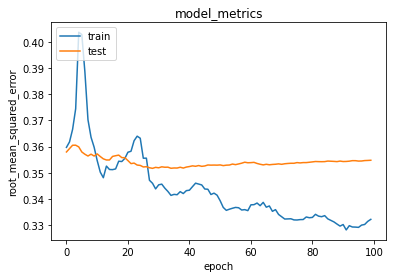

In [19]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Berdasarkan visualisasi diatas, dapat dilihat bahwa proses training mengalami naik turun yang cukup berubah-ubah atau tidak konstan dibandingan proses testing. Akan tetapi, meskipun demikian, dapat dilihat pula bahwa meskipun pada proses trainingnya tidak cukup halus, hasil akhir dari training memiliki nilai error dibawah 0,34 dan pada validasi sebesar 0,36 yang mana tidak terlalu buruk untuk sistem rekomendasi. 

## Getting New Recommendation

Langkah ini dilakukan untuk melihat performa model apakah dapat merekomendasikan tempat baru atau tidak. Mengingat yang akan direkomendasikan merupakan rekomendasi tempat, maka akan dibuat variabel baru yaitu place_have_not_visit yang berisikan daftar tempat yang belum pernah dikunjungi user. 

In [20]:
#deklarasi variabel
place = pd.read_csv('/content/id/tourism_with_id.csv')
rating = df
place

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,45.0,"{'lat': -7.4338593, 'lng': 112.7199058}",-7.433859,112.719906,NaN,433
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.291346799999999, 'lng': 112.7398218}",-7.291347,112.739822,NaN,434
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,45.0,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938,NaN,435
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753,NaN,436


In [21]:
#proses pembuatan variabel place_have_not_visit
user_id = rating.User_Id.sample(1).iloc[0]
place_have_not_visit = rating[rating.User_Id == user_id]
 
place_have_not_visit  = place[place['Place_Id'].isin(place_have_not_visit .Place_Id.values)]['Place_Id'] 
place_have_not_visit  = list(
    set(place_have_not_visit )
    .intersection(set(place_to_place_encoded.keys()))
)
 
place_have_not_visit = [[place_to_place_encoded.get(x)] for x in place_have_not_visit ]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_have_not_visit), place_have_not_visit )
)

In [22]:
#proses didapatkan rekomendasi tempat baru
ratings = model.predict(user_place_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_have_not_visit[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 11)
print('Top 10 place recommendation')
print('----' * 8)
 
recommended_place = place[place['Place_Id'].isin(recommended_place_ids)]
for row in recommended_place.itertuples():
    print(row.Place_Name, ':', row.City)


1/1 [==============================] - 0s 158ms/step
Showing recommendations for users: 158
Top 10 place recommendation
--------------------------------
Masjid Istiqlal : Jakarta
Alive Museum Ancol : Jakarta
Puncak Pinus Becici : Yogyakarta
Jogja Exotarium : Yogyakarta
Pantai Wediombo : Yogyakarta
Pantai Kesirat : Yogyakarta
Tafso Barn : Bandung
Kota Mini : Bandung
Chingu Cafe Little Seoul : Bandung
Gua Maria Kerep Ambarawa : Semarang


Berdasarkan hasil diatas, dapat dilihat bahwa model berhasil merekomendasikan tempat baru. Collaborative Filtering cukup mudah digunakan dan cepat dalam pemrosesannya akan tetapi mungkin terbatas pada filtering beberapa variabel saja. Untuk filtering dengan lebih banyak variabel, disarankan untuk dapat mecoba metode lain selain Collaborative Filtering.